#Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tqdm.notebook

# Classes and useful functions

###First we have created a class that represents an individuall. A set of these individuals shall compose our population for the algorithm. As the problem we aim to solve is the 8 queens puzzle, we have added the components that compose this problem to our class: an array containing a permutation of numbers from 0 to 7 representing the board and a matrix representation of this board (to easen the checking of conflicts). The remaining attributes is common to all evolutionary algorithm: fitness.

In [ ]:
class Individual:
    """
    A class that represents an individual.

    Attributes:
        internal_rep: the representation of the board as a list of integers
        matrix_rep: the matrix representation of the board, where each value
        represents a square of the board and can be 0 or 1, depending on whether
        the square is empty or not.
    """

    def __init__(self, array):
        """
        Initializes an instance of the individual.

        :param array: the representation of the board as a permutation.
        """
        if not isinstance(array, np.ndarray):
            raise TypeError("The array must be a ndarray")

        if len(array) != 8:
            raise ValueError("The array must have 8 elements")

        for element in array:
            if not isinstance(element, np.int64) or element < 0 or element > 7:
                raise ValueError("The array must contain only integers between 0 and 7")

        self._matrix_rep = None

        self._fitness = None

        self._internal_rep = None
        self.internal_rep = array


    @property
    def internal_rep(self):
        """
        Returns the internal representation of the board.

        :return: The internal representation of the board.
        """
        return self._internal_rep

    @internal_rep.setter
    def internal_rep(self, array):
        """
        Sets the internal representation of the board.

        :param value: The new internal representation of the board.
        """
        if not isinstance(array, np.ndarray):
            raise TypeError("The array must be a ndarray")

        if len(array) != 8:
            raise ValueError("The array must have 8 elements")

        for element in array:
            if not isinstance(element, np.int64) or element < 0 or element > 7:
                raise ValueError("The array must contain only integers between 0 and 7")

        self._internal_rep = array
        self._matrix_rep = [
            [0 if i != pos else 1 for i in range(8)] for pos in self.internal_rep
        ]
        self._fitness = self.__calculate_fitness()

    @property
    def matrix_rep(self):
        """
        Returns the matrix representation of the board.

        :return: The matrix representation of the board.
        """
        return self._matrix_rep

    @matrix_rep.setter
    def matrix_rep(self, value):
        """
        This function exists only to prevent writing to the matrix representation.
        """
        raise AttributeError("'Individual' object attribute 'matrix_rep' is read-only")

    @property
    def fitness(self):
        """
        Returns the fitness of the individual.

        :return: The fitness of the individual.
        """
        return self._fitness

    @fitness.setter
    def fitness(self, value):
        """
        This function exists only to prevent writing to the fitness.
        """
        raise AttributeError("'Individual' object attribute 'fitness' is read-only")

    def __calculate_conflicts(self, x, y):
        """
        Calculates the conflicts a specific queen.

        :param x: The x coordinate of the queen.
        :param y: The y coordinate of the queen.
        :return: The number of conflicts of the queen.
        """
        matrix = self.matrix_rep
        conflict = 0
        for i in range(8):
            for j in range(8):
                if matrix[i][j] == 1 and i != x and j != y:
                    if abs(x - i) == abs(y - j):
                        conflict = conflict + 1
        return conflict

    def __calculate_fitness(self):
        """
        Calculates the fitness of the individual.

        :return: The fitness of the individual.
        """
        fitness = 0
        matrix = self.matrix_rep
        for i in range(8):
            for j in range(8):
                if matrix[i][j] == 1:
                    fitness += self.__calculate_conflicts(i, j)
        return fitness
    
    def __str__(self):
        output = ""
        for i in range(len(self.internal_rep)):
            for j in range(len(self.internal_rep)):
                if self.internal_rep[i] == j:
                    output += "Q "
                else:
                    output += ". "
            output += "\n"
            
        return output

In [ ]:
def standard_deviation(individuals):
      return np.std([ind.fitness for ind in individuals], ddof=1)

class Population:
    def __init__(self, size): 
        self.size = size
        self._individuals = []

        for _ in range(size):
            permutation = np.random.permutation(8)
            self._individuals.append(Individual(permutation))
        self.standard_deviation = standard_deviation(self._individuals)

    @property
    def individuals(self):
      return self._individuals

    
    @individuals.setter
    def individuals(self, value):
      self._individuals = value
      self.standard_deviation = standard_deviation(self._individuals)
    
   

### On the next cell there are 3 functions. The first serves to transform an integer into an iterable array, it is used on the binarization process.

In [ ]:
def int_to_array(i):
    """
    This function receives an integer and returns a list of all the digits on the int
    :param i: The integer to be arrayed
    :return: The array of digits
    """
    
    temp = i
    answ = []
    while (temp>0):
      digit = temp % 10
      answ.append(digit)
      temp = int(temp/10)
    return answ
  

def de_binarize(son):
    """
    This function receives a binary array and returns a array with decimal numbers

    :param son: array made of binary numbers
    :return de_binarized_array: array of decimal integers
    """
    de_binarized_array = []
    for number in son:
      son_digits = int_to_array(number)
      de_bin_son_digit = 0
      for i, d in enumerate(son_digits):
        de_bin_son_digit+= d*2**i
      de_binarized_array.append(de_bin_son_digit)
    return np.array(de_binarized_array)
  

def binarize (parent):
    """ 
    This function return the binarized array representing a individual

    :param parent: the individual to have a array binazrized
    :return: the binarized array
    """
    binarized = []
    for i in parent.internal_rep:
      b = int(bin(i)[2:])
      binarized.append(b)
    
    return binarized


###Finally, we have the functions that we use to perform the evolution of our Population.

In [ ]:
def select_parents(pop):
    """
    This function selects the parents for an individual.

    :param pop: The population to select the parents from.
    :return: The parents.
    """
    possible_parents = np.random.choice(pop.individuals, 5)
    possible_parents = sorted(possible_parents, key=lambda x: x.fitness)
    
    return possible_parents[0], possible_parents[1]

def crossover (p1, p2):
    """
    This function makes the crossover of two parents.

    :param p1: The first parent.
    :param p2: The second parent.
    :return: The two generated sons
    """

    #First we binarize the parents
    binarized_p1 = binarize(p1)
    binarized_p2 = binarize(p2)

    #Then we perform the crossover algorithm
    son1 = binarized_p1[:4]
    son2 = binarized_p2[:4]

    #Since we want to start the crossover from the middle of the array, we create a new array to iterate over
    c_binarized_p1 = np.append(binarized_p1[4:],(binarized_p1[:4]))
    c_binarized_p2 = np.append(binarized_p2[4:],(binarized_p2[:4]))

    for i, (pos1, pos2) in enumerate (zip(c_binarized_p1, c_binarized_p2)):
      if not (pos2 in son1):
        son1.append(pos2)
      if not (pos1 in son2):
        son2.append(pos1)
    #Now we de-binarize the sons vectors, and return them
    son1 = Individual(np.array(de_binarize(son1)))
    son2 = Individual(np.array(de_binarize(son2)))
    return son1, son2
  

def mutate(individual):
    """
    This function mutates an individual.

    :param individual: The individual to mutate.
    """
    binarized_individual = binarize(individual)
    pos1 = np.random.randint(0, len(binarized_individual) - 1)
    pos2 = np.random.randint(0, len(binarized_individual) - 1)
    
    while (pos1 == pos2):
        pos2 = np.random.randint(0, len(binarized_individual) - 1)
    
    binarized_individual[pos1], binarized_individual[pos2] = binarized_individual[pos2], binarized_individual[pos1]
    
    individual.internal_rep = de_binarize(binarized_individual)
    return individual


In [ ]:
def evolve(pop, epochs, p_crossover, p_mutation, debug=False, progress_bar=False, stop_when_found=True, crossover_func=crossover):
    """
    This function evolves the population for a given number of epochs.

    :param pop: The population to evolve.
    """
    if debug == True:
      df = pd.DataFrame()
    
    iter = tqdm.notebook.tqdm(range(epochs), disable=(not progress_bar))
    found_at = None
    found_ind = None
    for epoch in iter:
        best_individual = min(pop.individuals, key=lambda x: x.fitness)

        if debug == True:
          fitness_array = np.array([ind.fitness for ind in pop.individuals])
          avg_fitness = fitness_array.mean()
          std_dev = fitness_array.std()

          current_itter = pd.DataFrame({"Iteration": [epoch], "Average Fitness": [avg_fitness], "Standard Deviation": [std_dev], "Best Individual": [best_individual.fitness]})
          df = pd.concat([df, current_itter], ignore_index=True)

        if found_at == None and best_individual.fitness == 0:
          found_at = epoch
          found_ind = best_individual
          if stop_when_found:
            if debug: return best_individual, epoch, df
            else: return best_individual, epoch 

        #Select Parents
        p1, p2 = select_parents(pop)
        #First, the two sons are equal to their parents
        s1, s2 = p1, p2
        #Crossover
        if(random.randint(1,10)/10>p_crossover):
          s1, s2 = crossover_func(p1,p2)
        #Mutation
        if(random.randint(1,10)/10>p_mutation):
          s1, s2= mutate(s1), mutate(s2)
        #Replacement ?
        new_pop = pop.individuals + [s1, s2]
        
        new_pop = sorted(new_pop, key=lambda x: x.fitness)
        new_pop = new_pop[:pop.size]
        pop.individuals = new_pop
    
    if stop_when_found:
      if debug: return None, epochs, df
      else: return None, epochs
    else:
      found_at = found_at if found_at != None else epochs
      if debug: return found_ind, found_at, df
      else: return found_ind, found_at

# Demonstrating the evolution

In [ ]:
pop = Population(100)
ind, epochs = evolve(p op, 10000, 0.9, 0.4, progress_bar=True)

print(ind)
print("Epochs:", epochs)

  0%|          | 0/10000 [00:00<?, ?it/s]

Q . . . . . . . 
. . . . . . Q . 
. . . Q . . . . 
. . . . . Q . . 
. . . . . . . Q 
. Q . . . . . . 
. . . . Q . . . 
. . Q . . . . . 

Epochs: 29


# Result Analysis Functions

In [ ]:
def generate_sample(size, epochs_limit, p_permutation=0.9, p_mutation=0.4, crossover_func=crossover):
  df = pd.DataFrame(data = {"epochs": [], "no_result": []})
  detail_df = pd.DataFrame()

  for _ in tqdm.notebook.tqdm(range(size)):
    pop = Population(100)
    ind, epochs, current_detail_df = evolve(pop, epochs_limit, p_permutation, p_mutation, debug=True, stop_when_found=True, crossover_func=crossover_func)

    detail_df = pd.concat([detail_df, current_detail_df], ignore_index=True)
    no_result = "True" if ind == None else "False"

    df2 = pd.DataFrame(data = {"epochs": [epochs], "no_result":[no_result]})
    df = pd.concat([df, df2], ignore_index = True)

  return df, detail_df

In [ ]:
def plot_sample(df, detail_df):
  no_result_count = len(df[df["no_result"] == "True"])
  sample_size = len(df)

  df = df[df["no_result"] == "False"]

  fig, axes = plt.subplots(1, 2, sharey=True)
  fig.suptitle("Distribution of number of epochs taken to reach a result")

  boxplot = sns.boxplot(data=df, y="epochs", ax=axes[0])
  boxplot.set_ylabel("Epochs count")

  histplot = sns.histplot(data=df, y="epochs", kde=True, ax=axes[1])
  plt.show()

  print(f"The average number of epochs taken to reach a result was: {df['epochs'].mean():.2f}")
  print(f"The median number of epochs taken to reach a result was: {df['epochs'].median():.2f}")
  print(f"Amount of times that no result was found: {no_result_count} ({no_result_count/sample_size * 100}%)")

  grouped_detail_df = detail_df.groupby("Iteration")
  avarages_df = grouped_detail_df[["Average Fitness", "Standard Deviation", "Best Individual"]].apply(lambda x: x.mean())
  
  fig, axes = plt.subplots(3, 1, sharex=True)

  fitnessplot = sns.lineplot(data=avarages_df, x="Iteration", y="Average Fitness", ax=axes[0])
  fitnessplot.set_ylabel("Avg Fit")
  std_devplot = sns.lineplot(data=avarages_df, x="Iteration", y="Standard Deviation", ax=axes[1])
  std_devplot.set_ylabel("Std Dev")
  best_indplot = sns.lineplot(data=avarages_df, x="Iteration", y="Best Individual", ax=axes[2])
  best_indplot.set_ylabel("Best Ind")
  plt.show()

# Analysing the results

In [ ]:
# Seaborn configs

sns.set_context("talk")
sns.set_style("darkgrid")

  0%|          | 0/100 [00:00<?, ?it/s]

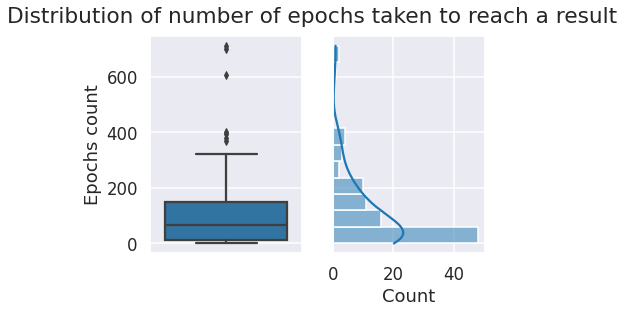

The average number of epochs taken to reach a result was: 113.71
The median number of epochs taken to reach a result was: 66.00
Amount of times that no result was found: 3 (3.0%)


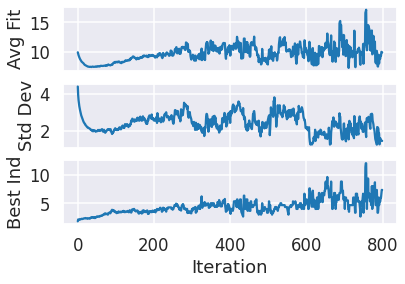

In [ ]:
df, detail_df = generate_sample(100, 800, 0.9, 0.4)
plot_sample(df, detail_df)

# Proposed changes

##Now we will modify the way crossover is performed. 


The goal is to increase exploitation: since the queens on the middle of the board are more likely to be on conflicts they are removed on the crossover.

In [ ]:
def custom_crossover (p1, p2):
    """
    This function makes the crossover of two parents.

    :param p1: The first parent.
    :param p2: The second parent.
    :return: The two generated sons
    """
    #First we binarize the parents
    binarized_p1 = binarize(p1)
    binarized_p2 = binarize(p2)

    #Then we perform the crossover algorithm
    #We keep the queens on the edge, for they are less subject to conflicts -> Increase exploitation
    son1 = binarized_p1[:2]
    son2 = binarized_p2[:2]
    for i, j in zip (binarized_p1[6:], binarized_p2[6:]):
      son1.append(i)
      son2.append(j)

    #Crossover starts from yet unexplored genes, then goes into unexplored ones
    c_binarized_p1 = np.append(binarized_p1[2:6], binarized_p1[:2])
    c_binarized_p1 = np.append(c_binarized_p1, binarized_p1[6:])
    c_binarized_p2 = np.append(binarized_p2[2:6], binarized_p2[:2])
    c_binarized_p2 = np.append(c_binarized_p2, binarized_p2[6:])

    son1_complement = []
    son2_complement = []
    for i, (pos1, pos2) in enumerate (zip(c_binarized_p1, c_binarized_p2)):
      if not (pos2 in son1):
        son1_complement.append(pos2)
      if not (pos1 in son2):
        son2_complement.append(pos1)

    #Finally, the complements are inserted on the sons
    for s1_i, s2_i in zip (son1_complement, son2_complement):
      son1.insert(2, s1_i)
      son2.insert(2, s2_i)
    #Now we de-binarize the sons vectors, and return them
    son1 = Individual(np.array(de_binarize(son1)))
    son2 = Individual(np.array(de_binarize(son2)))
    return son1, son2

  0%|          | 0/100 [00:00<?, ?it/s]

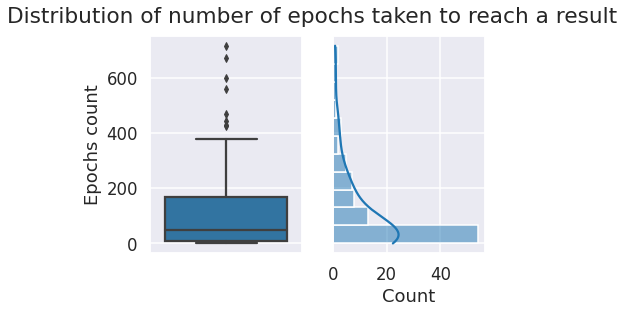

The average number of epochs taken to reach a result was: 118.78
The median number of epochs taken to reach a result was: 47.00
Amount of times that no result was found: 3 (3.0%)


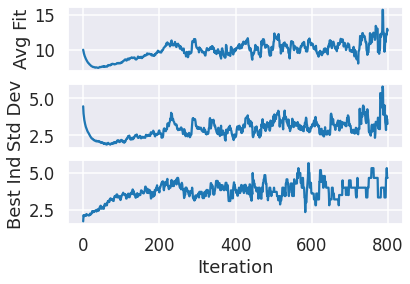

In [ ]:
df, detail_df = generate_sample(100, 800, 0.9, 0.4, crossover_func=custom_crossover)
plot_sample(df, detail_df)

# Fine-tuning the mutation and crossover probabilities

The high mutation probability might be causing an excessive amount of exploitation. Let's counter that by tweaking the probability.

  0%|          | 0/100 [00:00<?, ?it/s]

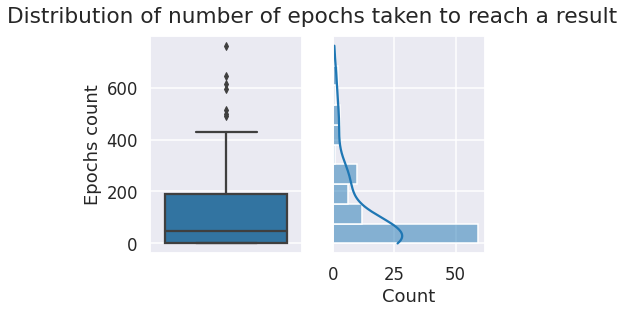

The average number of epochs taken to reach a result was: 120.16
The median number of epochs taken to reach a result was: 48.00
Amount of times that no result was found: 2 (2.0%)


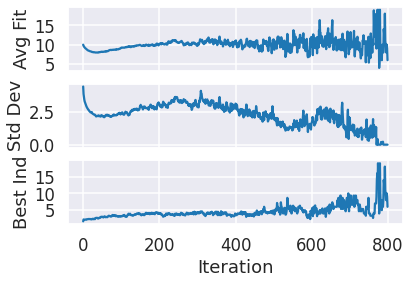

In [ ]:
p_cross = 0.9
p_mut = 0.1
df, detail_df = generate_sample(100, 800, p_cross, p_mut, crossover_func=custom_crossover)
plot_sample(df, detail_df)

But sometimes, having a high mutation probability might be benefitial. Let's try applying a function to the best fitness to find the mutation probability. 
This will let us exploit good characteristics while still being able to escape local minimums.

In [ ]:
def cust_evolve(pop, epochs, p_crossover, p_mutation, debug=False, progress_bar=False, stop_when_found=True, crossover_func=crossover):
    """
    This function evolves the population for a given number of epochs.

    :param pop: The population to evolve.
    """
    if debug == True:
      df = pd.DataFrame()
    

    iter = tqdm.notebook.tqdm(range(epochs), disable=(not progress_bar))
    found_at = None
    found_ind = None
    for epoch in iter:
        best_individual = min(pop.individuals, key=lambda x: x.fitness)
        p_mutation = (2 ** (1/(5 * ((28 - best_individual.fitness) / 15))) - 1)
        p_mutation = max(p_mutation, 0.05)
        p_mutation = min(p_mutation, 0.8)

        if debug == True:
          fitness_array = np.array([ind.fitness for ind in pop.individuals])
          avg_fitness = fitness_array.mean()
          std_dev = fitness_array.std()

          current_itter = pd.DataFrame({"Iteration": [epoch], "Average Fitness": [avg_fitness], "Standard Deviation": [std_dev], "Best Individual": [best_individual.fitness], "P_Mut": [p_mutation]})
          df = pd.concat([df, current_itter], ignore_index=True)

        if found_at == None and best_individual.fitness == 0:
          found_at = epoch
          found_ind = best_individual
          if stop_when_found:
            if debug: return best_individual, epoch, df
            else: return best_individual, epoch 

        #Select Parents
        p1, p2 = select_parents(pop)
        #First, the two sons are equal to their parents
        s1, s2 = p1, p2
        #Crossover
        if(random.randint(1,10)/10>p_crossover):
          s1, s2 = crossover_func(p1,p2)
        #Mutation
        if(random.randint(1,10)/10>p_mutation):
          s1, s2= mutate(s1), mutate(s2)
        #Replacement ?
        new_pop = pop.individuals + [s1, s2]
        
        new_pop = sorted(new_pop, key=lambda x: x.fitness)
        new_pop = new_pop[:pop.size]
        pop.individuals = new_pop
    
    if stop_when_found:
      if debug: return None, epochs, df
      else: return None, epochs
    else:
      found_at = found_at if found_at != None else epochs
      if debug: return found_ind, found_at, df
      else: return found_ind, found_at

  0%|          | 0/100 [00:00<?, ?it/s]

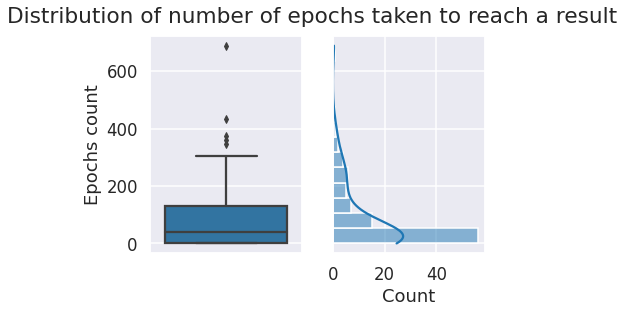

The average number of epochs taken to reach a result was: 88.33
The median number of epochs taken to reach a result was: 39.00
Amount of times that no result was found: 2 (2.0%)


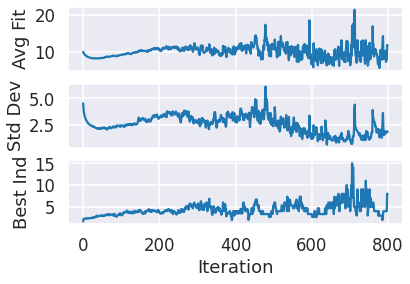

In [ ]:
evolve = cust_evolve
p_cross = 0.9
p_mut = None
df, detail_df = generate_sample(100, 800, p_cross, p_mut, crossover_func=custom_crossover)
plot_sample(df, detail_df)

#sns.lineplot(data=grouped_detail_df, x="Iteration", y="P_Mut")
#plt.show()